In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from jcopml.time_series import stationarity_tester
from jcopml.time_series.decomposition import additive_decomposition
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.3f}'.format)


### Import Dataset dari Local Database

In [4]:
df = pd.read_csv('data_time_series.csv')
df.head()

,Date,TransactionID,CustomerID,ProductID,StoreID,Qty,TotalAmount,StoreName,GroupStore,Type,Latitude,Longitude,Age,Gender,Marital Status,Income,Product Name,Price
0,2022-01-01,TR11369,328,P3,12,4,30000,Prestasi Utama,Prestasi,General Trade,-2.991,104.757,36,False,Married,10.530,Crackers,7500
1,2022-01-01,TR16356,165,P9,1,7,70000,Prima Tendean,Prima,Modern Trade,-6.200,106.817,44,True,Married,14.580,Yoghurt,10000
2,2022-01-01,TR1984,183,P1,4,4,35200,Gita Ginara,Gita,General Trade,-6.967,110.417,27,True,Single,0.180,Choco Bar,8800
3,2022-01-01,TR35256,160,P1,4,7,61600,Gita Ginara,Gita,General Trade,-6.967,110.417,48,True,Married,12.570,Choco Bar,8800
4,2022-01-01,TR41231,386,P9,4,1,10000,Gita Ginara,Gita,General Trade,-6.967,110.417,33,False,Married,6.950,Yoghurt,10000


### Exploratory Data Analysis

In [5]:
print(f"Dataset terdiri dari {df.shape[0]} baris dan {df.shape[1]} kolom")
print(f"Dataset memiliki {df['Marital Status'].isnull().sum().sum()} nilai kosong")
print(f"Dataset memiliki {df.duplicated().sum()} data duplikat")

Dataset terdiri dari 4976 baris dan 18 kolom
Dataset memiliki 0 nilai kosong
Dataset memiliki 0 data duplikat


<b>Memperbaiki tipe data</b>

In [6]:
df.dtypes

Date               object
TransactionID      object
CustomerID          int64
ProductID          object
StoreID             int64
Qty                 int64
TotalAmount         int64
StoreName          object
GroupStore         object
Type               object
Latitude          float64
Longitude         float64
Age                 int64
Gender               bool
Marital Status     object
Income            float64
Product Name       object
Price               int64
dtype: object

In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df['CustomerID'] = df['CustomerID'].astype('object')
df['StoreID'] = df['StoreID'].astype('object')
df['Marital Status'] = df['Marital Status'].astype('category')

df.dtypes

Date              datetime64[ns]
TransactionID             object
CustomerID                object
ProductID                 object
StoreID                   object
Qty                        int64
TotalAmount                int64
StoreName                 object
GroupStore                object
Type                      object
Latitude                 float64
Longitude                float64
Age                        int64
Gender                      bool
Marital Status          category
Income                   float64
Product Name              object
Price                      int64
dtype: object

<b>Melihat data tanggal yang hilang</b>

In [8]:
date_min = df['Date'].min()
date_max = df['Date'].max()

df = df.set_index('Date')
print("Dates which are missing", pd.date_range(
  start=date_min, end=date_max).difference(df.index))
df = df.reset_index()

Dates which are missing DatetimeIndex([], dtype='datetime64[ns]', freq=None)


<b>Melihat Tahun dan Bulan pada dataset</b>

In [9]:
print(df['Date'].dt.year.unique())
print(list(df['Date'].dt.month_name().unique()))

[2022]
['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


### Preprocessing

<b>Memproses data dengan mengambil jumlah Qty yang terjual pada setiap harinya</b>

In [10]:
data = df.groupby('Date').agg({'Qty': 'sum'}).reset_index()
data_clustering = data.copy()
df_time_series = data.copy().set_index('Date')

print(f"Dataset terdiri dari {df_time_series.shape[0]} baris dan {df_time_series.shape[1]} kolom")
df_time_series.head()

Dataset terdiri dari 365 baris dan 1 kolom


,Qty
Date,
2022-01-01,49
2022-01-02,50
2022-01-03,76
2022-01-04,98
2022-01-05,67


<b>Melihat hasil visualisasi data</b>

<AxesSubplot:title={'center':'Daily Sales'}, xlabel='Date'>

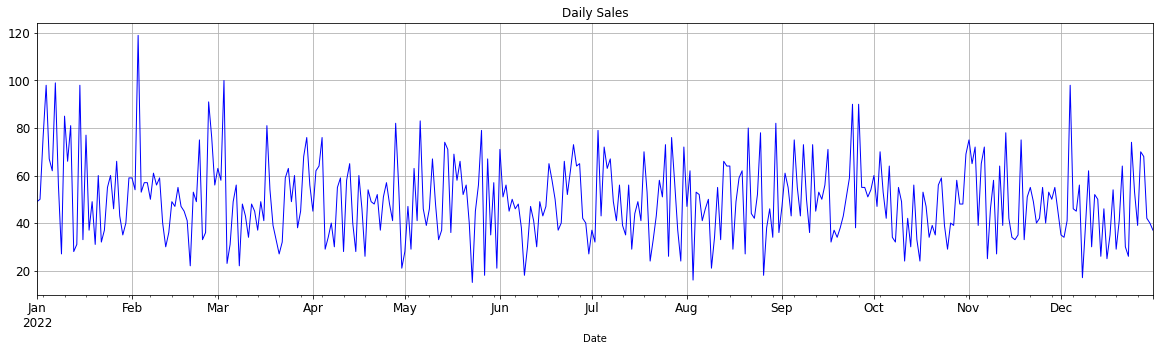

In [11]:
df_time_series.plot(figsize=(20, 5), color='blue', linewidth=1, fontsize=12, legend=None, title='Daily Sales', grid=True)

<b>Melihat statistik data apakah data termasuk stationer atau tidak</b>

In [12]:
def test_stationarity(data):
    # Menghitung statistik ADF
    result = adfuller(data)
    print('ADF Statistik:', result[0])
    print('P-value:', result[1])
    print('Banyaknya observasi:', result[3])
    print('Nilai kritis:')
    for key, value in result[4].items():
        print('\t', key, ':', value)

    # Melakukan pengecekan p-value
    if result[1] <= 0.05:
        print("Data bersifat stasioner.")
    else:
        print("Data tidak stasioner.")

# Memanggil fungsi untuk menguji kestasioneran data
test_stationarity(df_time_series)

ADF Statistik: -19.091513872408132
P-value: 0.0
Banyaknya observasi: 364
Nilai kritis:
	 1% : -3.4484434475193777
	 5% : -2.869513170510808
	 10% : -2.571017574266393
Data bersifat stasioner.


In [13]:
stationarity_tester(df_time_series)

ADF:        Series is stationary
KPSS:       Series is trend stationary
Conclusion: Series is stationary


,Test Statistic,p-value,Critical Value (1%),Critical Value (5%),Critical Value (10%),reject_null
ADF,-19.092,0.000,-3.448,-2.870,-2.571,True
KPSS,0.380,0.086,0.739,0.463,0.347,False


<b>Melihat ACF dan PACF untuk menentukan nilai p untuk PACF dan q untuk ACF</b>

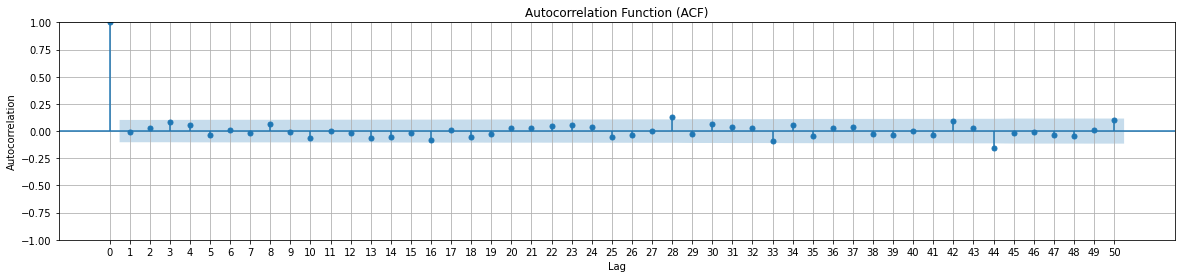

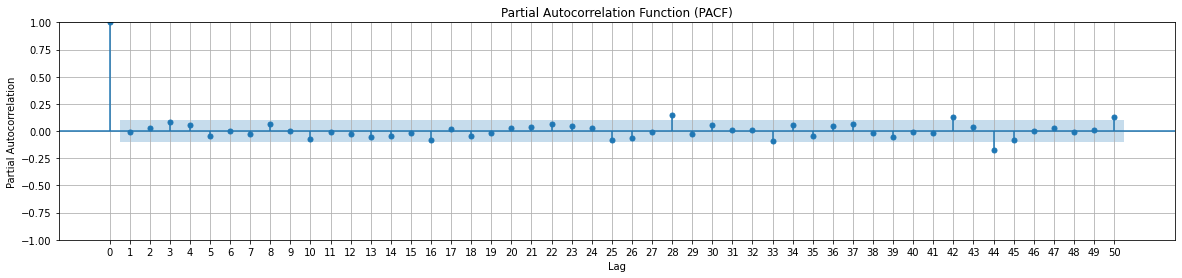

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
fig, ax = plt.subplots(figsize=(20, 4))
plot_acf(df_time_series, ax=ax, lags=50)
plt.xticks(np.arange(0, 51, 1))
plt.grid(True)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
fig, ax = plt.subplots(figsize=(20, 4))
plot_pacf(df_time_series, ax=ax, lags=50)
plt.xticks(np.arange(0, 51, 1))
plt.grid(True)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

**ACF** = q <br>
**PACF** = p

### ARIMA

<b>Pemodelan menggunakan ARIMA dengan p = 28, d = 0, q = 28</b>

In [29]:
import time

start_time = time.time()

arima = ARIMA(df_time_series, order=(28, 0, 28))
model_arima = arima.fit()

end_time = time.time()
execution_time = end_time - start_time

pred = model_arima.predict()
actual = df_time_series

mse_arima = mean_squared_error(actual, pred)
rmse_arima = np.sqrt(mse_arima)
mae_arima = mean_absolute_error(actual,pred)
r2_arima = r2_score(actual,pred)

print("MSE\t: ", mse_arima)
print("RMSE\t: ", rmse_arima)
print("MAE\t: ", mae_arima)
print("R2\t: ", r2_arima)

MSE	:  235.91743849754528
RMSE	:  15.359604112656852
MAE	:  12.053855772987417
R2	:  0.15489240591827602


<b>Melihat visualisasi hasil data aktual dan data prediksi</b>

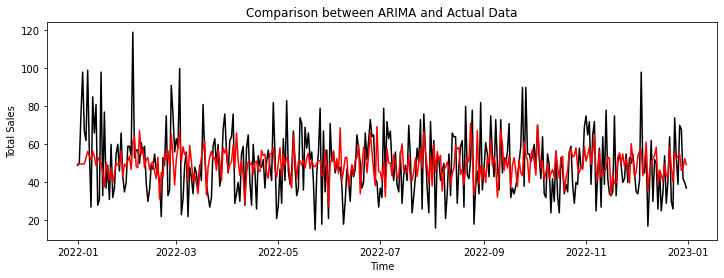

In [33]:
index_list = df_time_series.index.tolist()
preds = model_arima.predict()
preds = preds.set_axis(index_list)
preds = preds.to_frame()

fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.title(f'Comparison between ARIMA and Actual Data')
plt.xlabel('Time')
plt.ylabel("Total Sales")

plt.plot(df_time_series, label = 'Actual', color = 'black')
plt.plot(preds, label = 'Predicted', color = 'r')

<b>Melakukan prediksi untuk 1 bulan kedepan</b>

In [34]:
last_date = df_time_series.reset_index().at[len(df_time_series)-1, 'Date']
print(f"Tanggal Terakhir\t\t: {last_date}")

forecast_date = pd.to_datetime(last_date) + pd.DateOffset(days=1)
print(f"Tanggal Forecast Dimulai Dari\t: {forecast_date}")

forecast = model_arima.forecast(steps=30) #Forecasting for N days 
forecast_index = pd.date_range(start=forecast_date, periods=30)
data_forecast = pd.DataFrame({'Forecast':forecast.values}, index=forecast_index)

data_forecast

Tanggal Terakhir		: 2022-12-31 00:00:00
Tanggal Forecast Dimulai Dari	: 2023-01-01 00:00:00


,Forecast
2023-01-01,57.633
2023-01-02,53.666
2023-01-03,54.053
2023-01-04,57.777
2023-01-05,38.840
2023-01-06,39.773
2023-01-07,48.812
2023-01-08,42.814
2023-01-09,49.908
2023-01-10,58.027


<b>Menampilkan visualisasi hasil prediksi</b>

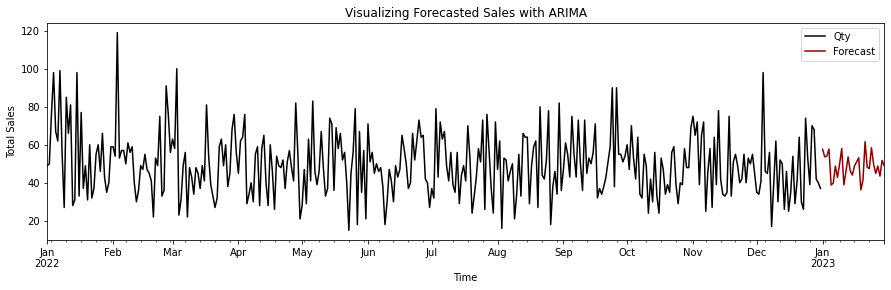

In [38]:
ci = data_forecast.values
ax = df_time_series.plot(label='Past Sales', color='black', figsize=(20, 15))
data_forecast.plot(ax=ax,label='Forecasted Sales', color='darkred')

ax.set_xlabel('Date')
ax.set_ylabel('Total Sales')
fig = plt.gcf()
fig.set_size_inches(15, 4)
plt.legend()

plt.title(f'Visualizing Forecasted Sales with {"ARIMA"}')
plt.xlabel('Time')
plt.ylabel("Total Sales")
plt.show()

### Kesimpulan

In [40]:
r2_percentage = f"{r2_arima*100:.2f} %"
pd.DataFrame({'MSE':mse_arima, 'RMSE': rmse_arima, 'MAE': mae_arima, 'R2': r2_percentage, 'Execution Time': execution_time}, index=['ARIMA'])

,MSE,RMSE,MAE,R2,Execution Time
ARIMA,235.917,15.360,12.054,15.49 %,26.191
